In [1]:
# Initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
pd.options.display.max_columns = None
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
# Read data info a data frame and preview data structure
lend = pd.read_csv('data/lending_clean.csv')
display(lend.head())

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,debt_settlement_flag,loan_start_d,yr_emp,yr_credit,revol_util_dec,target
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,Dec-2018,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2011-12-01,10.0,26.0,0.837,1
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-2013,119.66,Oct-2016,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2011-12-01,0.0,12.0,0.094,0
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5%,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-2014,649.91,Jun-2017,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2011-12-01,10.0,10.0,0.985,1
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,other,personel,917xx,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21%,37.0,f,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-2015,357.48,Apr-2016,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2011-12-01,10.0,15.0,2.100,1
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,80000.0,Source Verified,Dec-2011,Fully Paid,n,other,Personal,972xx,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9%,38.0,f,0.0,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-2017,67.30,Apr-2018,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2011-12-01,1.0,15.0,0.539,1


#### Reminder: target 0 means loan was default, while 1 means loan was repaid in full

Look at default rate based loan issue dates

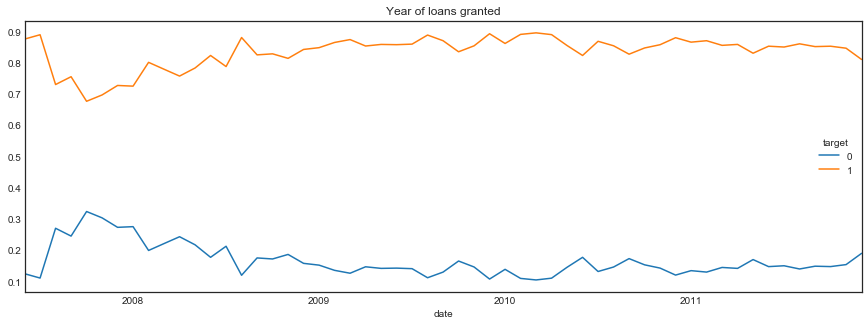

In [3]:
loan_start = lend.groupby(['loan_start_d', 'target'])[['target']].count().unstack(level=1)
loan_start = loan_start.apply(lambda r:r/r.sum(), axis=1)
loan_start['date'] = pd.to_datetime(loan_start.index)
loan_start.plot(x='date', y='target', kind='line', figsize =(15, 5), title='Year of loans granted');

Loan issued during 2008 and prior had higher default rate, probably due to financial crisis. Given one cannot predict when the next financial crisis is going to happen, data within 2007 and 2008 are outliers for the dataset and would need to be removed from the analysis

In [4]:
# creating new dataframe by including data post 2019/1/1
lend_2009on = lend[lend['loan_start_d'] >= '2009-1-1']

To simplify the repetition steps for creating visualization, the following function is created.This function calculate the % of loans that were paid off (target = 1) within the categorical values of a particular feature (x).

In [5]:
def visual_data(x):
    y = lend_2009on.groupby([x,'target'])[['target']].count().unstack(level=1)
    z = y.apply(lambda r: r/r.sum(), axis=1)
    return z

#### The following attributes will be assessed
- Employment length
- Property ownership
- Loan purpose
- Credit line history
- Debt to income ratio (DTI)
- Credit utilization rate
- State of the applicants

#### Employment length

          target          
target         0         1
yr_emp                    
0.0     0.144778  0.855222
1.0     0.148552  0.851448
2.0     0.136574  0.863426
3.0     0.142026  0.857974
4.0     0.134112  0.865888
5.0     0.141610  0.858390
6.0     0.143545  0.856455
7.0     0.149849  0.850151
8.0     0.143170  0.856830
9.0     0.130137  0.869863
10.0    0.155441  0.844559


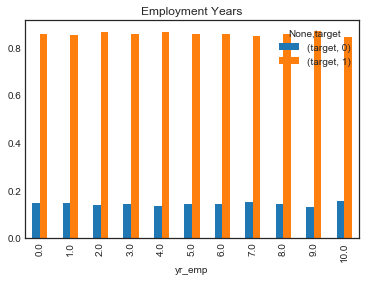

In [6]:
emp_data = visual_data('yr_emp')
emp_data.plot(kind='bar', title='Employment Years');
print(emp_data)

- Employment time does not indicate obvious correlation on loan pay off rate

#### Property Ownership

                  target          
target                 0         1
home_ownership                    
MORTGAGE        0.135025  0.864975
OTHER           0.400000  0.600000
OWN             0.152465  0.847535
RENT            0.157820  0.842180


RENT        16861
MORTGAGE    16471
OWN          2840
OTHER          10
Name: home_ownership, dtype: int64

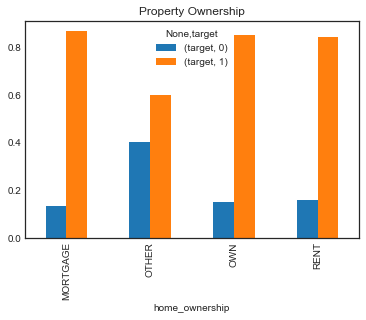

In [7]:
ownership = visual_data('home_ownership')
ownership.plot(kind='bar', title='Property Ownership');
print(ownership)
lend_2009on['home_ownership'].value_counts()

- Owning a mortgage has ~2% high paid off rate. We cannot determine whether 2% is significant at this time. We will access this feature more in inference statistics later. Other category has high default rate but the small sample size does make the correlation significant

#### Loan Purpose

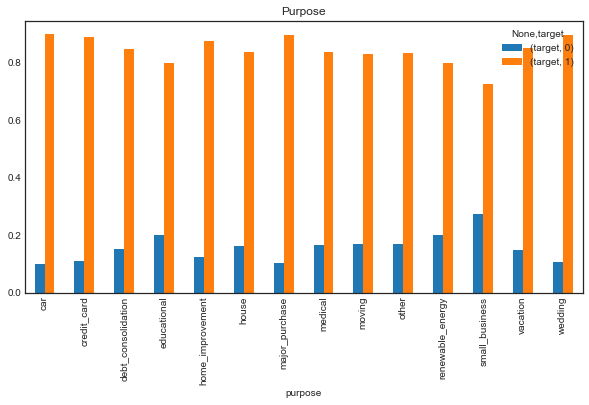

In [8]:
loan_purpose = visual_data('purpose')
loan_purpose.plot(kind='bar', figsize=(10,5), title='Purpose');

- Default rate varies by purpose. Among those, educational and small_business seem to have highest charge off rate, versus wedding has the lowest.

In [9]:
# Apply the function to the rest of the potential features
yr_credit_g = visual_data('yr_credit')
dti_g = visual_data('dti')
revutil = visual_data('revol_util_dec')
cred_acc = visual_data('total_acc')
state = visual_data('addr_state')

#### Credit History in years

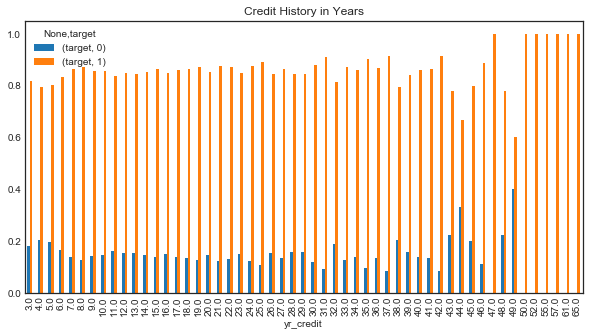

In [10]:
yr_credit_g.plot(kind='bar', figsize=(10,5), title='Credit History in Years');

 - Charge off rate go up from 0-5yrs, then gradually drop toward 10yrs. Post that the default rate stay roughly the same till 30 yrs plus, and that could be driven by outliers due to small sample size.
 
 Double check on the records which has more than 50 years of credit history to ensure its validity.

In [11]:
lend_2009on[lend_2009on.yr_credit > 50]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,debt_settlement_flag,loan_start_d,yr_emp,yr_credit,revol_util_dec,target
6137,4800.0,4800.0,4800.0,36 months,6.03%,146.10,A,A1,NaN,RENT,20400.0,Verified,Oct-2011,Fully Paid,n,debt_consolidation,Debt Consolidation Loan,769xx,TX,19.24,0.0,1954-10-01,0.0,10.0,0.0,10324.0,27.6%,21.0,f,0.0,0.0,5259.228314,5259.23,4800.0,459.23,0.0,0.0,0.0,Oct-2014,147.48,Oct-2014,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2011-10-01,NaN,57.0,0.2760,1
13997,6000.0,6000.0,6000.0,36 months,5.42%,180.96,A,A1,NaN,MORTGAGE,130000.0,Source Verified,Jun-2011,Fully Paid,n,other,Other Loan,619xx,IL,15.29,0.0,1959-06-01,3.0,9.0,0.0,2467.0,8.3%,40.0,f,0.0,0.0,6514.520632,6514.52,6000.0,514.52,0.0,0.0,0.0,Jun-2014,192.89,Jul-2017,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2011-06-01,NaN,52.0,0.0830,1
14015,15000.0,15000.0,15000.0,36 months,10.99%,491.01,B,B3,7 years,MORTGAGE,87000.0,Source Verified,Jun-2011,Fully Paid,n,small_business,Small Business Loan,297xx,SC,12.01,0.0,1956-09-01,0.0,9.0,1.0,4611.0,47.5%,21.0,f,0.0,0.0,17611.526923,17611.53,15000.0,2611.53,0.0,0.0,0.0,Jan-2014,2913.86,Jun-2017,0.0,1.0,Individual,0.0,0.0,0.0,1.0,0.0,N,N,2011-06-01,7.0,55.0,0.4750,1
14118,6000.0,6000.0,6000.0,36 months,10.59%,195.27,B,B2,6 years,MORTGAGE,33360.0,Not Verified,Jun-2011,Fully Paid,n,home_improvement,Pool & Installation,648xx,MO,0.00,0.0,1946-01-01,0.0,5.0,2.0,0.0,0%,7.0,f,0.0,0.0,7029.694131,7029.69,6000.0,1029.69,0.0,0.0,0.0,Jun-2014,207.04,Sep-2014,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2011-06-01,6.0,65.0,0.0000,1
15315,22500.0,14475.0,12675.0,60 months,10.37%,310.20,B,B3,2 years,MORTGAGE,45000.0,Verified,May-2011,Fully Paid,n,home_improvement,suite,212xx,MD,12.00,0.0,1950-12-01,0.0,8.0,0.0,15011.0,43.9%,20.0,f,0.0,0.0,14601.240000,12785.67,14475.0,126.24,0.0,0.0,0.0,Jun-2011,14602.51,Jun-2011,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2011-05-01,2.0,61.0,0.4390,1
22098,15000.0,15000.0,15000.0,36 months,14.83%,518.74,D,D3,10+ years,RENT,88000.0,Source Verified,Dec-2010,Fully Paid,n,debt_consolidation,Debt Consolidation,105xx,NY,17.32,1.0,1954-11-01,2.0,3.0,0.0,0.0,4.85%,22.0,f,0.0,0.0,18676.177979,18676.18,15000.0,3676.18,0.0,0.0,0.0,Jan-2014,560.01,Jan-2014,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2010-12-01,10.0,57.0,0.0485,1


Confirm that records are valid. These applicants have their earliest credit lines back in the 1950s

#### DTI (Debt to Income ratio)

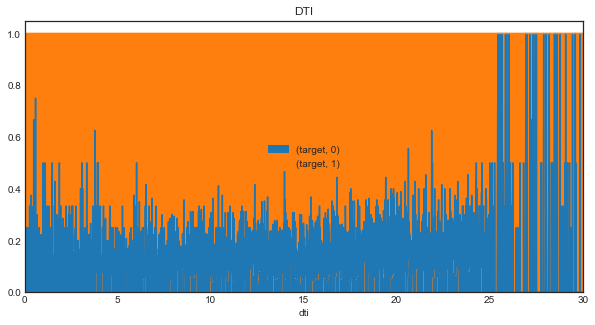

In [12]:
dti_g.plot(kind='area', figsize=(10,5), title='DTI');
plt.legend(loc='center')

 - No obvious correlation is observed

#### Credit usage

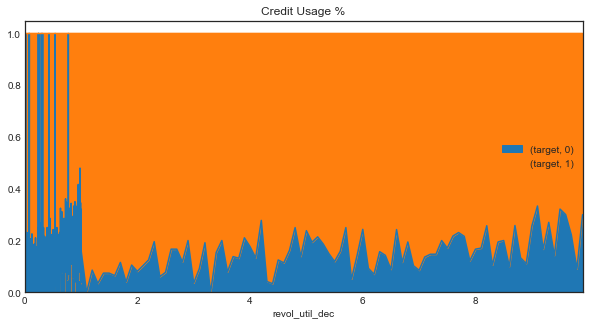

In [13]:
revutil.plot(kind='area', figsize=(10,5), title='Credit Usage %');
plt.legend(loc='best')

- No obvious correlation is observed

### Number of credit lines

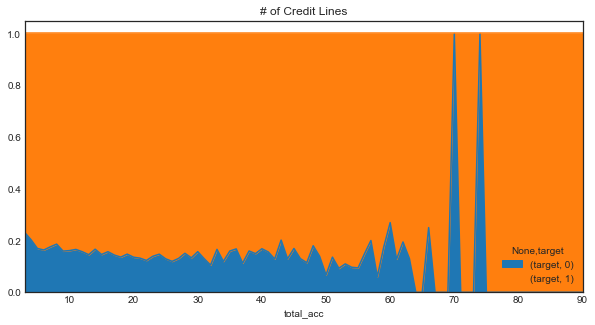

In [14]:
cred_acc.plot(kind='area', figsize=(10,5), title='# of Credit Lines');

- Number of credit line is slightly inversely correlated to default rates

#### Applicant's state

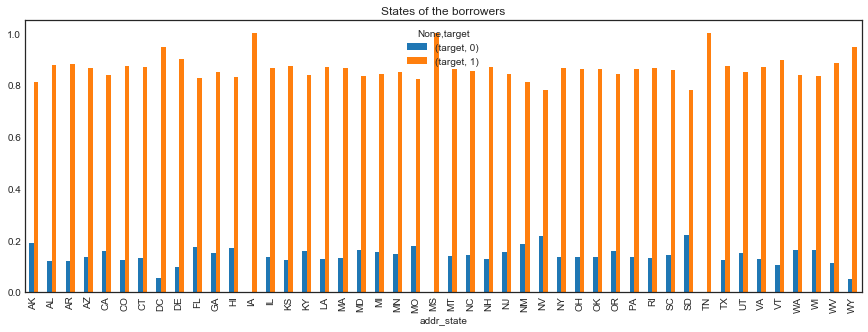

In [15]:
state.plot(kind='bar', figsize=(15,5), title='States of the borrowers');

- States location seem to impact the loan paid off rate

In [16]:
# Take a look into state which has 100% paid off rate
lend_2009on[(lend_2009on['addr_state'] == 'TN') | (lend_2009on['addr_state'] == 'IA') | (lend_2009on['addr_state'] == 'MS')]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,debt_settlement_flag,loan_start_d,yr_emp,yr_credit,revol_util_dec,target
4760,6000.0,6000.0,6000.0,36 months,15.27%,208.79,C,C4,10+ years,OWN,106870.0,Source Verified,Oct-2011,Fully Paid,n,credit_card,Help loan,397xx,MS,15.99,0.0,1984-05-01,1.0,11.0,0.0,20782.0,66%,35.0,f,0.0,0.0,6364.681189,6364.68,6000.0,364.68,0.0,0.0,0.0,Apr-2012,5533.30,Apr-2019,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2011-10-01,10.0,27.0,6.600,1
5429,28000.0,28000.0,27975.0,36 months,7.90%,876.13,A,A4,5 years,MORTGAGE,120000.0,Verified,Oct-2011,Fully Paid,n,small_business,Business Loan 2011,380xx,TN,16.67,0.0,1994-10-01,1.0,6.0,0.0,21064.0,46.1%,13.0,f,0.0,0.0,29634.803651,29608.34,28000.0,1634.80,0.0,0.0,0.0,Aug-2012,21753.99,May-2015,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2011-10-01,5.0,17.0,0.461,1
29843,9600.0,9600.0,9600.0,36 months,7.14%,297.04,A,A3,6 years,MORTGAGE,51996.0,Not Verified,May-2010,Fully Paid,n,debt_consolidation,Great Credit looking to consolidate,527xx,IA,24.60,0.0,1998-10-01,1.0,18.0,0.0,8179.0,16.9%,28.0,f,0.0,0.0,10709.316559,10709.32,9600.0,1094.32,15.0,0.0,0.0,Jun-2013,320.33,May-2013,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N,2010-05-01,6.0,13.0,0.169,1


While TN, IA, and MS have 100% paid off rate, each state only has one loan records. Hence, it is not significant finding.

### Recommendations

- Loan Purposes has noticeable impact on the loan repayment rate. Loans to fund new businesses have the highest default rate. Loans for major life events such as wedding and major purchases have lower chance of default.
- Observed difference in paid off rates among state. However states like MS, TN & IA do not have enough records. We will need to group state information to a higher level.
- Years of credit history, DTI, number of credit lines, property ownership indicate some correlation to loan default rates, and will need further analysis
- Employment history do not indicates relationship to the loan paid off rates.

To save time for the inferent statistics and machine learning part, save a copy of the condensed dataset with selected features above

In [17]:
lend_ml = lend_2009on[['home_ownership','purpose', 'yr_credit', 'dti', 'revol_util_dec', 'total_acc', 'addr_state', 'target']]
lend_ml.to_csv('data/lending_ml.csv', index=False)

[Back to README](https://github.com/sittingman/lending_repayment)